# Molecular Dynamics: Lennard-Jones system

Today we will be performing some basic molecular dynamics (MD) simulation of a Lennard-Jones system (i.e., a system of particles interacting via a Lennard-Jones potential). We will be performing several simulations under both the canonical (NVT) and Isothermal-Isobaric (NPT) ensembles.

**NOTE:** This tutorial has been adapted from the LJ tutorial located at https://bitbucket.org/glotzer/hoomd-examples.

**NOTE:** A detailed description of all HOOMD-Blue commands can be found at https://hoomd-blue.readthedocs.io/en/stable/.

## Description

This tutorial will walk through the basic steps of a MD simulation under the NVT and NPT ensembles.

The general steps will be as follows:
1. Creation of the system of interest in mBuild
2. Saving said system to a format that HOOMD-Blue can read
3. Initialize the system and simulation information in HOOMD-Blue
4. Define the potential energy function and particle velocities
5. Select the integrator
6. Perform NVT simulation and log thermodynamic properties
7. Perform NPT simulation and log thermodynamic properties
8. Compare differences between two ensembles

## System Generation

To begin, we will use the `Pattern` class from mBuild to build a 3D grid of 125 Lennard-Jones particles.

In [1]:
import mbuild as mb

# Create a particle, we give it the name "C" for visualization purposes only
lj = mb.Particle(name='C')

# Pack a simulation box (6x6x6) with 20 LJ particles
lj_box = mb.fill_box(lj, n_compounds=20, box=mb.Box([6,6,6]))

/Users/ayang41/Programs/mbuild/mbuild/box.py:34: UserWarning: Provided `lengths` and `mins` and/or `maxs`. Only `lengths` is being used. You provided: lengths=[6, 6, 6] mins=None maxs=None
  "lengths={} mins={} maxs={}".format(lengths, mins, maxs)



Lets visualize this compound.

In [2]:
lj_box.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Saving the box to a format usable by HOOMD-Blue

Now that we have generated the box of Lennard-Jones particles, it is time to migrate to a simulation engine.

For this example, we will use HOOMD-Blue. MoSDeF has support built in for saving to both HOOMDXML and GSD file formats, which are used by HOOMD-Blue.

We will be using the HOOMDXML file format, which is both human and machine readable, compared to GSD which is a binary file format. 

In [3]:
lj_box.save(filename='lj_box.hoomdxml', overwrite=True, ref_distance=1)
lj_box.save(filename='lj_box.mol2', overwrite=True)

/Users/ayang41/Programs/mbuild/mbuild/utils/decorators.py:21: Warning: write_hoomdxml has breaking change. See PR#463 on github
  warn(printed_message, Warning)


Lets take a look at the beginning of the file, see if you can find how many particles are in the system and the dimensions of our box containing our system.

In [4]:
!head -n 10 ./lj_box.hoomdxml

<?xml version="1.2" encoding="UTF-8"?>
<hoomd_xml version="1.2">
<!-- ref_distance (nm) ref_mass (amu) ref_energy (kJ/mol) -->
<!-- 10 1.0 0.2390057361376673 -->
<configuration time_step="0">
<box units="sigma"  Lx="6.0" Ly="6.0" Lz="6.0"/>
<position units="sigma" num="20">
1.0352192000000002	-2.2398901	-0.7810777000000002
-2.6876006	-1.9391765999999997	0.2714781000000002
0.9043080000000003	0.46958139999999987	0.1304162000000005


## Initialize the Simulation Engine

Now that we have generated the Lennard-Jones particles from mBuild and have saved the system to a file format suitable for HOOMD-Blue, it is now time to initialize the engine.

To begin, we need to import the HOOMD python package and the MD component to run Molecular Dyanmics simulations.

HOOMD-Blue is migrating to the GSD file format, which is deprecating the HOOMDXML file. However, they still support reading in this file format, we just need to import the `hoomd.deprecated` module. 

In [5]:
import hoomd
import hoomd.md
import hoomd.deprecated

/Users/ayang41/anaconda3/envs/mosdef37/lib/python3.7/site-packages/hoomd/context.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  CLOCK_START = time.clock()


Initialize the execution context to control where HOOMD will execute the simulation. When no command line options are provided, HOOMD will auto-select a GPU if it exists, or run on the CPU.

In [6]:
hoomd.context.initialize("")

HOOMD-blue 2.5.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 04/30/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


Read in our HOOMDXML file we generated from the Lennard-Jones box of particles in mBuild. If we have any particles outside of the box that HOOMD is trying to read, `wrap_coordinates=True` will put those back into the box.

In [7]:
lattice = hoomd.deprecated.init.read_xml(filename='lj_box.hoomdxml', wrap_coordinates=True)

notice(2): Reading lj_box.hoomdxml...
notice(2): Parser for node <bond_coeffs> not defined, ignoring
notice(2): Parser for node <angle_coeffs> not defined, ignoring
notice(2): Parser for node <dihedral_coeffs> not defined, ignoring
notice(2): --- hoomd_xml file read summary
notice(2): 20 positions at timestep 0
notice(2): 20 masses
notice(2): 1 particle types
notice(2): 20 charges
notice(2): Group "all" created containing 20 particles


Initialize particle velocities from a Gaussian distribution.

In [8]:
import random
random.seed(1)
T_init = 0.1
for p in lattice.particles:
    p.velocity = (random.gauss(0, T_init), random.gauss(0, T_init), random.gauss(0, T_init))

## Define potential energy

$ V(r) = 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right] $, where $r$ < $r$<sub>cut</sub>

In the Lennard-Jones system, pairs of particles closer than $r_\mathrm{cut}$ interact with this potential energy.

Choose the neighbor list acceleration structure to find neighboring particles efficiently. In systems with only one cutoff length, the cell method performs best.

**NOTE:** In a moment you will learn more about neighbor lists and will define the interaction potential.

In [9]:
#nl = hoomd.md.nlist.cell(r_buff=0.6, check_period=1)
nl = hoomd.md.nlist.cell()

## Select integrator

In [10]:
hoomd.md.integrate.mode_standard(dt=0.01)

The integrator defines the equations of motion that govern the system of particles, given the current configuration of the particles and the net force from all potentials. The standard integration mode in HOOMD allows different integrators to apply to different groups of particles with the same step size $dt$.

Apply NVT integration using the Velocity-Verlet algorithm.

In [11]:
all = hoomd.group.all()
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=1.0)

Above, this is using the [Nosé-Hoover thermostat](https://hoomd-blue.readthedocs.io/en/stable/module-md-integrate.html#hoomd.md.integrate.nvt). We define the `group` as all the particles in the system, since we want to integrate the entire system under the same thermostat. However, we could select different sections of particles and integrate them under different conditions if we want.

`kT` is the average temperature we want the group to have. In this case, we want the entire system (`all`) to have an average temperature of 0.2kT.

`tau` is a term related to the Nosé-Hoover thermostat, essentially it describes the fictitious thermal bath that will provide the temperature source for our system. See the above link for more information. 


Next we want to make sure that we zero the total linear momentum of the system - this avoids what is termed the "flying ice cube" problem.

In [12]:
hoomd.md.update.zero_momentum()

Define the functional form of the pair interaction and evaluate using the given neighbor list acceleration structure.

In [13]:
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)

Specify pair potential parameters for every pair of types in the simulation. Since all of our particles are the same, we only need to set the interaction parameters for two `C` particles.

In [14]:
epsilon = 1
sigma = 1

lj.pair_coeff.set('C', 'C', epsilon=epsilon, sigma=sigma)

Lets plot the lennard jones potential based on the interaction parameters we defined above. Change the sigma and epsilon values and observe how this changes the potential energy function

Text(0, 0.5, 'U')

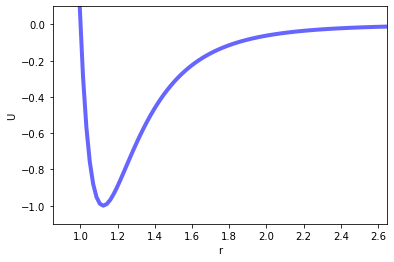

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

cms = 2.5 - sigma
rmin = sigma - cms * 0.1
rmax = 2.5 + cms * 0.1

r = np.linspace(start=rmin, stop=rmax, num=100,)
potential = (4 * epsilon) * ( (sigma / r)**12 - (sigma/r)**6 )
min_U = np.min(potential)

fig, ax = plt.subplots()
ax.plot(r[:], potential[:], linestyle='-', color='#6666ff', lw=4)

ax.set_xlim(rmin, rmax)
ax.set_ylim(min_U * 1.1, -0.1 * min_U)
ax.set_xlabel('r')
ax.set_ylabel('U')

## Neighbor list searching

Since the pair potential (Lennard-Jones) is based on the interactions of all the particles interacting with one another no matter how far they are separated from each other, it should be noted that as the amount of particles increase, the performance will drastically decrease.

However, as we can see above, beyond a certain distance `r`, the potential energy of two particles asymptotically approaches 0. This means that we do not need to actually determine all the interactions between each particles if they are separated beyond a certain distance. These interactions will contribute a negligible amount in the overall potential energy of the system.

This is where the concept of neighbor lists comes into play. Knowing when the `r` value between two particles is large enough to minimally count towards the total potential energy the particle is experiencing can increase performance handily. 

Neighbor lists can be thought of as the local neighborhood of important particles for each particle in the system. Usually much smaller than the total number of particles present, these are the only particles that need to be accounted for when evaluating the interaction energies.

There are many algorithms that have been developed to efficiently and accurately track the neighbor lists, a common one that is used is the cell list method.

<img src="cell_list.png" alt="Drawing" style="width: 500px;" />

Shown above is a cartoon representing the cell list method. The cutoff distance is determined by the largest radius of the particles in the simulation. There is an additional "skin" region that extends past the cutoff distance, to reduce the total amount of recalculations of the neighbor lists. 

From HOOMD-Blue's documentation:
>A small buffer radius (skin layer) `r_buff` is typically added to the cutoff radius so that the neighbor list can be computed less frequently. The neighbor list must only be rebuilt any time a particle diffuses `r_buff/2`. However, increasing r_buff also increases the number of particles that are included in the neighbor list, which slows down the pair force evaluation. A balance can be obtained between the two by optimizing `r_buff`.

An important aspect of optimizing molecular dynamics simulations are choosing optimal parameters for the neighbor lists.

HOOMD-Blue has a built-in `tune` tool to optimize the neighbor list settings, below we will use that to increase the performance of the following simulation.

In [16]:
#nl.tune(warmup=10000, set_max_check_period=False)
#nl.tune(warmup=1000)

## Write output

The `hoomd.analyze.log` method can be used to log a variety of system properties (see http://hoomd-blue.readthedocs.io/en/stable/module-hoomd-analyze.html#hoomd.analyze.log). Here we will periodically log the volume, temperature, kinetic energy, potential energy, and pressure.

In [17]:
hoomd.analyze.log(filename="analyze_nvt.log",
                  quantities=['temperature', 'volume', 'kinetic_energy', 'potential_energy', 'pressure'],
                  period=10,
                  overwrite=True)

Periodically write the particle configurations to a DCD file.

In [18]:
hoomd.dump.dcd("trajectory.dcd", period=1e3, group=all, overwrite=True, unwrap_full=False)

## Run the simulation

Take 1e5 steps forward in time.

In [19]:
hoomd.run(1e5)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 20
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:01 | Step 100000 / 100000 | TPS 108853 | ETA 00:00:00
Average TPS: 108773
---------
-- Neighborlist stats:
1006 normal updates / 1000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 19 / n_neigh_avg: 9.05
shortest rebuild period: 3
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 0 / n_max: 8 / n_avg: 2.5
** run complete **


## Examine the output

Use matplotlib to plot the volume, temperature, total_energy, and pressure.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

data_nvt = np.genfromtxt(fname='analyze_nvt.log', skip_header=True);

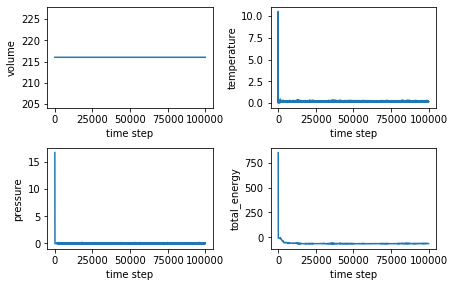

In [21]:
plt.figure();


plt.subplot(221);
plt.plot(data_nvt[:,0], data_nvt[:,2]);
plt.xlabel('time step');
plt.ylabel('volume');

plt.subplot(222);
plt.plot(data_nvt[:,0], data_nvt[:,1]);
plt.xlabel('time step');
plt.ylabel('temperature');

plt.subplot(223);
plt.plot(data_nvt[:,0], data_nvt[:,5]);
plt.xlabel('time step');
plt.ylabel('pressure');

plt.subplot(224);
plt.plot(data_nvt[:,0], data_nvt[:,3] + data_nvt[:,4]);
plt.xlabel('time step');
plt.ylabel('total_energy');

# adjust subplots so they do not overlap with each other
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1.0, hspace=0.4,
                    wspace=0.35)

plt.show()

Examine how these values change or are constant. Since we are in the NVT ensemble, we should expect the number of particles, volume, and temperature to be constant. Which is what we observe. 

## NPT Ensemble

Now that we have ran under the NVT ensemble for some time, lets switch over to the NPT ensemble. This can be done in multiple ways, but the simplest way is to disable the current NVT integrator and enable the NPT integrator.

We will change the names of the log files, but that is the majority of the work required. 

In [22]:
nvt.disable()

npt = hoomd.md.integrate.npt(group=all, kT=0.5, tau=1.0, P=0.003, tauP=10)

Now lets set the data logging information

In [23]:
hoomd.analyze.log(filename="analyze_npt.log",
                  quantities=['temperature', 'volume', 'kinetic_energy', 'potential_energy', 'pressure'],
                  period=100,
                  overwrite=True)

hoomd.run(1e5)

** starting run **
Time 00:00:03 | Step 200000 / 200000 | TPS 143964 | ETA 00:00:00
Average TPS: 143765
---------
-- Neighborlist stats:
2430 normal updates / 1000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 3 / n_neigh_avg: 0.7
shortest rebuild period: 22
-- Cell list stats:
Dimension: 5, 5, 5
n_min    : 0 / n_max: 2 / n_avg: 0.16
** run complete **


Now lets plot the NPT thermodynamic data. Compare this to the NVT data. Which properties are constant, what previously constant properties are now changing?
- **Hint**
    - The description of the ensemble (NPT, NVT, etc) describes the constant variables in the simulation

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

data_npt = np.genfromtxt(fname='analyze_npt.log', skip_header=True);

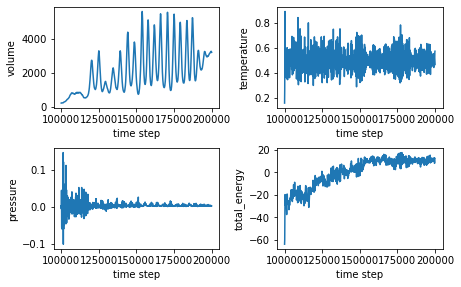

In [25]:
plt.figure();


plt.subplot(221);
plt.plot(data_npt[:,0], data_npt[:,2]);
plt.xlabel('time step');
plt.ylabel('volume');

plt.subplot(222);
plt.plot(data_npt[:,0], data_npt[:,1]);
plt.xlabel('time step');
plt.ylabel('temperature');

plt.subplot(223);
plt.plot(data_npt[:,0], data_npt[:,5]);
plt.xlabel('time step');
plt.ylabel('pressure');

plt.subplot(224);
plt.plot(data_npt[:,0], data_npt[:,3] + data_npt[:,4]);
plt.xlabel('time step');
plt.ylabel('total_energy');

# adjust subplots so they do not overlap with each other
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1.0, hspace=0.4,
                    wspace=0.35)

plt.show()

Now lets look at our system!

In [26]:
import nglview as nv
import mdtraj as md

In [27]:
traj = md.load(filename_or_filenames='./trajectory.dcd', top='./lj_box.mol2')
nv.show_mdtraj(traj)

NGLWidget(count=200)